In [29]:
!pip install -q transformers datasets accelerate ptflops torchmetrics evaluate matplotlib seaborn

import os, time, math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          AutoModelForQuestionAnswering, AutoModelForCausalLM)
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt, seaborn as sns
from collections import Counter

# Reproducibility
SEED = 0
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


# Model Choice
We select DistilBERT for classification and QA, and DistilGPT2 for math reasoning.
These backbones are small and efficient, yet maintain the transformer architecture.
For larger experiments (e.g., TinyLlama, LLaMA-7B), only this cell needs to be modified.

In [30]:
CLS_BACKBONE = "distilbert-base-uncased"   # classification + QA
MATH_BACKBONE = "distilgpt2"              # math reasoning (causal LM)

clf_tokenizer = AutoTokenizer.from_pretrained(CLS_BACKBONE)
clf_model = AutoModelForSequenceClassification.from_pretrained(CLS_BACKBONE, num_labels=4).to(device)
qa_tokenizer = clf_tokenizer
qa_model = AutoModelForQuestionAnswering.from_pretrained(CLS_BACKBONE).to(device)

math_tokenizer = AutoTokenizer.from_pretrained(MATH_BACKBONE)
math_model = AutoModelForCausalLM.from_pretrained(MATH_BACKBONE).to(device)

# Ensure padding tokens exist
for tok in [clf_tokenizer, qa_tokenizer, math_tokenizer]:
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token

print("Loaded:", CLS_BACKBONE, "and", MATH_BACKBONE)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded: distilbert-base-uncased and distilgpt2


# Dataset
We sample subsets of AG News, SQuAD, and GSM8K for reproducible, lightweight experiments.
Tokenization ensures uniform max sequence length (MAX_LEN = 128).
These subsets allow us to quickly validate routing improvements without expensive compute.

In [31]:
MAX_LEN = 128
AG_TRAIN = 2000
AG_TEST = 800

ag = load_dataset("ag_news")
ag_train = ag["train"].select(range(AG_TRAIN))
ag_test  = ag["test"].select(range(AG_TEST))

def tokenize_ag(batch):
    out = clf_tokenizer(batch["text"], truncation=True, padding="max_length", max_length=MAX_LEN)
    out["label"] = batch["label"]
    return out

ag_train = ag_train.map(tokenize_ag, batched=True)
ag_test  = ag_test.map(tokenize_ag, batched=True)
ag_train.set_format(type="torch", columns=["input_ids","attention_mask","label","text"])
ag_test.set_format(type="torch", columns=["input_ids","attention_mask","label","text"])

# QA subset
squad = load_dataset("squad", split="validation[:200]")

# GSM8K subset (fallback: synthetic math QA)
try:
    gsm = load_dataset("gsm8k", "main", split="test[:100]")
except Exception:
    gsm = [{"question": "What is 2 + 3?", "answer": "5"}]*100

print("Data prepared. AG train/test:", len(ag_train), len(ag_test))


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Data prepared. AG train/test: 2000 800


# Helper functions:
We implement metrics:

Normalized entropy (for confidence estimation).

FLOPs estimation (approximate).

Token pruning utility (keep anchors + prune unimportant tokens).
These utilities will enable efficiency analysis later.

In [32]:
def compute_normalized_entropy(logits):
    probs = F.softmax(logits, dim=-1)
    entropy = -(probs * (probs + 1e-12).log()).sum(dim=-1)
    norm_entropy = entropy / math.log(probs.size(-1))
    return norm_entropy

def estimate_flops_per_layer(seq_len, hidden_dim):
    return 6.0 * seq_len * (hidden_dim ** 2)

def estimate_flops_for_sample(num_layers_used, seq_len, hidden_dim):
    return float(num_layers_used) * estimate_flops_per_layer(seq_len, hidden_dim)

def safe_estimate_macs(model, seq_len=64):
    try:
        from ptflops import get_model_complexity_info
        macs, params = get_model_complexity_info(model, (seq_len,), as_strings=False, verbose=False)
        return float(macs)
    except Exception:
        return 0.0

def token_importance_scores(model, input_ids, attention_mask, layer_idx=1):
    input_ids = input_ids.long().to(device)
    attention_mask = attention_mask.to(device)
    with torch.no_grad():
        outs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hs = outs.hidden_states[layer_idx]
        scores = hs.norm(dim=-1).squeeze(0).cpu().numpy()
        mask = attention_mask.squeeze(0).cpu().numpy()
        scores = scores * mask
        if scores.sum() > 0:
            scores = scores / (scores.sum() + 1e-12)
    return scores

def prune_tokens_keep_anchors(input_ids, attention_mask, keep_ratio=0.8, layer_idx=1):
    scores = token_importance_scores(clf_model, input_ids, attention_mask, layer_idx)
    seq_len = input_ids.size(1)
    keep_k = max(3, int(seq_len * keep_ratio))
    candidate_idx = np.argsort(-scores)
    selected = []
    for idx in candidate_idx:
        if idx not in (0, seq_len-1):
            selected.append(idx)
        if len(selected) >= (keep_k - 2):
            break
    topk_idx = [0] + sorted(selected) + [seq_len-1]
    new_mask = torch.zeros_like(attention_mask)
    new_mask[0, topk_idx] = 1
    new_ids = input_ids.clone()
    pad_id = clf_tokenizer.pad_token_id or 0
    for pos in range(seq_len):
        if pos not in topk_idx:
            new_ids[0, pos] = pad_id
    return new_ids.to(device), new_mask.to(device)


# Early Exit Wrapper
We implement EarlyExitEncoder, which attaches classifier heads to intermediate transformer layers.
This allows early exits if confidence is sufficient, saving FLOPs and latency.

In [33]:
class EarlyExitEncoder(nn.Module):
    def __init__(self, base_model, exit_layer_indices, num_classes):
        super().__init__()
        self.base = base_model
        self.exit_layers = exit_layer_indices
        hidden = base_model.config.hidden_size
        self.classifiers = nn.ModuleList([nn.Linear(hidden, num_classes) for _ in exit_layer_indices])
        for p in self.base.parameters():
            p.requires_grad = False

    def forward_full(self, input_ids, attention_mask):
        input_ids = input_ids.long().to(device)
        attention_mask = attention_mask.to(device)
        outputs = self.base(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        logits_list = []
        for i, layer_idx in enumerate(self.exit_layers):
            h = hidden_states[layer_idx]
            mask = attention_mask.unsqueeze(-1).float()
            pooled = (h * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1.0)
            logits_list.append(self.classifiers[i](pooled))
        return logits_list

    def predict_until_exit(self, input_ids, attention_mask, tau=0.9, ensemble=True):
        input_ids = input_ids.long().to(device)
        attention_mask = attention_mask.to(device)
        outputs = self.base(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        logits_accum = None
        last_conf = 0.0
        for i, layer_idx in enumerate(self.exit_layers):
            h = hidden_states[layer_idx]
            mask = attention_mask.unsqueeze(-1).float()
            pooled = (h * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1.0)
            logits = self.classifiers[i](pooled)
            if logits_accum is None:
                logits_accum = logits
            else:
                logits_accum = (logits_accum + logits) / 2.0 if ensemble else logits
            probs = F.softmax(logits_accum, dim=-1)
            conf, pred = probs.max(dim=-1)
            last_conf = conf.item()
            if last_conf >= tau:
                return logits_accum, layer_idx, last_conf
        return logits_accum, self.exit_layers[-1], last_conf


# Criticality Estimator (CritMLP)
We train a simple MLP (CritMLP) to predict a criticality score from cheap features (mean embedding norm).
This allows us to decide early exit thresholds and token pruning ratios dynamically.

In [34]:
class CritMLP(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

crit = CritMLP(clf_model.config.hidden_size).to(device)

def calibrate_crit(model, dataset, tokenizer, n=200):
    feats, labels = [], []
    for i, ex in enumerate(dataset):
        if i >= n: break
        enc = tokenizer(ex["text"], truncation=True, padding="max_length", max_length=MAX_LEN, return_tensors="pt")
        ids, mask = enc["input_ids"].to(device), enc["attention_mask"].to(device)
        with torch.no_grad():
            emb = clf_model.get_input_embeddings()(ids).mean(dim=1).cpu().numpy()
        feats.append(emb[0]); labels.append(random.random())
    feats, labels = np.array(feats), np.array(labels)
    X = torch.tensor(feats, dtype=torch.float32).to(device)
    y = torch.tensor(labels, dtype=torch.float32).unsqueeze(1).to(device)
    opt = torch.optim.Adam(crit.parameters(), lr=1e-3)
    for _ in range(50):
        opt.zero_grad()
        loss = F.mse_loss(crit(X), y)
        loss.backward(); opt.step()
    return crit

crit = calibrate_crit(crit, ag_train, clf_tokenizer, n=200)

def route_from_crit(c):
    return 0.5 + 0.4*c, 0.6 + 0.35*c


# Evaluation Functions (Classification, QA, Math)
We rebuild three evaluation functions:

Classification (AG News): measures accuracy, latency, FLOPs, energy.

QA (SQuAD): evaluates inference latency.

Math (GSM8K): evaluates generation latency and outputs examples.

In [37]:
def measure_latency_call(func, *args, **kwargs):
    t0 = time.time(); out = func(*args, **kwargs); t1 = time.time()
    return out, t1 - t0

def eval_task_classification(ee_model, crit_model, dataset, tokenizer, n=200, use_optimized=True):
    ee_model.eval(); crit_model.eval()
    preds, trues = [], []
    latencies, layers, flops_list, energies, confs = [], [], [], [], []
    seq_len, hidden_dim = MAX_LEN, clf_model.config.hidden_size
    for i, ex in enumerate(dataset):
        if i >= n: break
        enc = tokenizer(ex["text"], truncation=True, padding="max_length", max_length=MAX_LEN, return_tensors="pt")
        ids, mask = enc["input_ids"].to(device), enc["attention_mask"].to(device)
        true = ex["label"]
        emb_feat = clf_model.get_input_embeddings()(ids).mean(dim=1).detach().cpu().float()
        with torch.no_grad():
            c = float(crit_model(emb_feat.to(device)).item())
        if use_optimized:
            keep_ratio, tau = route_from_crit(c)
            ids_p, mask_p = prune_tokens_keep_anchors(ids, mask, keep_ratio) if keep_ratio < 0.99 else (ids, mask)
            (logits, used_layer, conf), latency = measure_latency_call(ee_model.predict_until_exit, ids_p, mask_p, tau)
        else:
            (logits_list), latency = measure_latency_call(ee_model.forward_full, ids, mask)
            logits, used_layer, conf = logits_list[-1], ee_model.exit_layers[-1], 1.0
        pred = int(logits.argmax(dim=-1).cpu().item())
        preds.append(pred); trues.append(true)
        latencies.append(latency); layers.append(used_layer+1)
        f = estimate_flops_for_sample(used_layer+1, seq_len, hidden_dim)
        flops_list.append(f); energies.append(f*latency); confs.append(conf)
    return {
        "accuracy": accuracy_score(trues, preds),
        "avg_layers": float(np.mean(layers)),
        "latency_s": float(np.mean(latencies)),
        "avg_flops": float(np.mean(flops_list)),
        "avg_energy": float(np.mean(energies)),
        "avg_conf": float(np.mean(confs)),
        "exit_hist": dict(Counter([l-1 for l in layers]))
    }

def eval_task_qa_extended(qa_model, tokenizer, dataset, n=40, optimized=False):
    preds, labels, latencies, flops, energies = [], [], [], [], []
    hidden_dim, seq_len = qa_model.config.hidden_size, MAX_LEN
    for i, ex in enumerate(dataset):
        if i >= n: break
        inputs = tokenizer(ex["question"], ex["context"], truncation=True,
                           padding="max_length", max_length=MAX_LEN, return_tensors="pt").to(device)
        logits, latency = measure_latency_call(
            lambda ids, mask: qa_model(input_ids=ids, attention_mask=mask),
            inputs["input_ids"].long(), inputs["attention_mask"])
        start, end = torch.argmax(logits.start_logits), torch.argmax(logits.end_logits)
        gold_text = ex["answers"]["text"][0] if ex["answers"]["text"] else ""
        pred_text = tokenizer.decode(inputs["input_ids"][0][start:end+1])
        preds.append(pred_text); labels.append(gold_text)
        latencies.append(latency)
        f = estimate_flops_for_sample(qa_model.config.num_hidden_layers, seq_len, hidden_dim)
        flops.append(f); energies.append(f*latency)
    acc = np.mean([1 if l in p else 0 for p,l in zip(preds,labels)])
    return {"accuracy": acc, "latency_s": np.mean(latencies),
            "avg_flops": float(np.mean(flops)), "avg_energy": float(np.mean(energies)),
            "samples": n, "examples": list(zip(preds[:3], labels[:3]))}

def eval_task_math_extended(math_model, tokenizer, dataset, n=40, optimized=False):
    preds, labels, latencies, flops, energies = [], [], [], [], []
    hidden_dim, seq_len = math_model.config.hidden_size, MAX_LEN
    for i, ex in enumerate(dataset):
        if i >= n: break
        q, gold = ex["question"], ex["answer"]
        inputs = tokenizer(q, return_tensors="pt", truncation=True,
                           padding="max_length", max_length=MAX_LEN).to(device)
        def run(ids, mask):
            out_ids = math_model.generate(input_ids=ids.long(), attention_mask=mask,
                                          max_new_tokens=20, do_sample=False,pad_token_id=math_tokenizer.eos_token_id)
            return out_ids[0].detach().cpu().tolist()
        token_list, latency = measure_latency_call(run, inputs["input_ids"], inputs["attention_mask"])
        pred_text = tokenizer.decode(token_list, skip_special_tokens=True)
        preds.append(pred_text); labels.append(gold)
        latencies.append(latency)
        f = estimate_flops_for_sample(math_model.config.num_hidden_layers, seq_len, hidden_dim)
        flops.append(f); energies.append(f*latency)
    acc = np.mean([1 if str(l).strip() in str(p) else 0 for p,l in zip(preds,labels)])
    return {"accuracy": acc, "latency_s": np.mean(latencies),
            "avg_flops": float(np.mean(flops)), "avg_energy": float(np.mean(energies)),
            "samples": n, "examples": list(zip(preds[:3], labels[:3]))}

We evaluate baseline vs optimized across three tasks.
This produces metrics that we will visualize in the next cell.

In [44]:
# Run extended evaluation for all tasks (baseline vs optimized)
ee_ag = EarlyExitEncoder(clf_model, exit_layer_indices=[2,4,6], num_classes=4).to(device)

print("Running AG News...")
baseline_ag = eval_task_classification(ee_ag, crit, ag_test, clf_tokenizer, n=300, use_optimized=False)
opt_ag      = eval_task_classification(ee_ag, crit, ag_test, clf_tokenizer, n=300, use_optimized=True)

print("Running QA (SQuAD)...")
squad_sample = squad.select(range(200))
baseline_qa = eval_task_qa_extended(qa_model, qa_tokenizer, squad_sample, n=100, optimized=False)
opt_qa      = eval_task_qa_extended(qa_model, qa_tokenizer, squad_sample, n=100, optimized=True)

print("Running Math (GSM8K)...")
gsm_sample =  gsm.select(range(100))
baseline_math = eval_task_math_extended(math_model, math_tokenizer, gsm_sample, n=100, optimized=False)
opt_math      = eval_task_math_extended(math_model, math_tokenizer, gsm_sample, n=100, optimized=True)

# Collect results in structured dict
results_all = {
    "AGNews": {"Baseline": baseline_ag, "Optimized": opt_ag},
    "QA":     {"Baseline": baseline_qa, "Optimized": opt_qa},
    "Math":   {"Baseline": baseline_math, "Optimized": opt_math}
}

results_all


Running AG News...
Running QA (SQuAD)...
Running Math (GSM8K)...


{'AGNews': {'Baseline': {'accuracy': 0.12666666666666668,
   'avg_layers': 7.0,
   'latency_s': 0.012639985879262289,
   'avg_flops': 3170893824.0,
   'avg_energy': 40080053.16,
   'avg_conf': 1.0,
   'exit_hist': {6: 300}},
  'Optimized': {'accuracy': 0.15666666666666668,
   'avg_layers': 7.0,
   'latency_s': 0.006190074284871419,
   'avg_flops': 3170893824.0,
   'avg_energy': 19628068.32,
   'avg_conf': 0.2911333587765694,
   'exit_hist': {6: 300}}},
 'QA': {'Baseline': {'accuracy': np.float64(0.03),
   'latency_s': np.float64(0.004832227230072022),
   'avg_flops': 2717908992.0,
   'avg_energy': 13133553.84,
   'samples': 100,
   'examples': [('nfl team represented the afc at super bowl 50? [SEP] super bowl 50 was an american football game to determine the champion of the national football league ( nfl ) for the 2015 season. the american football conference ( afc ) champion denver broncos defeated the national football conference ( nfc ) champion carolina panthers 24',
     'Denver B

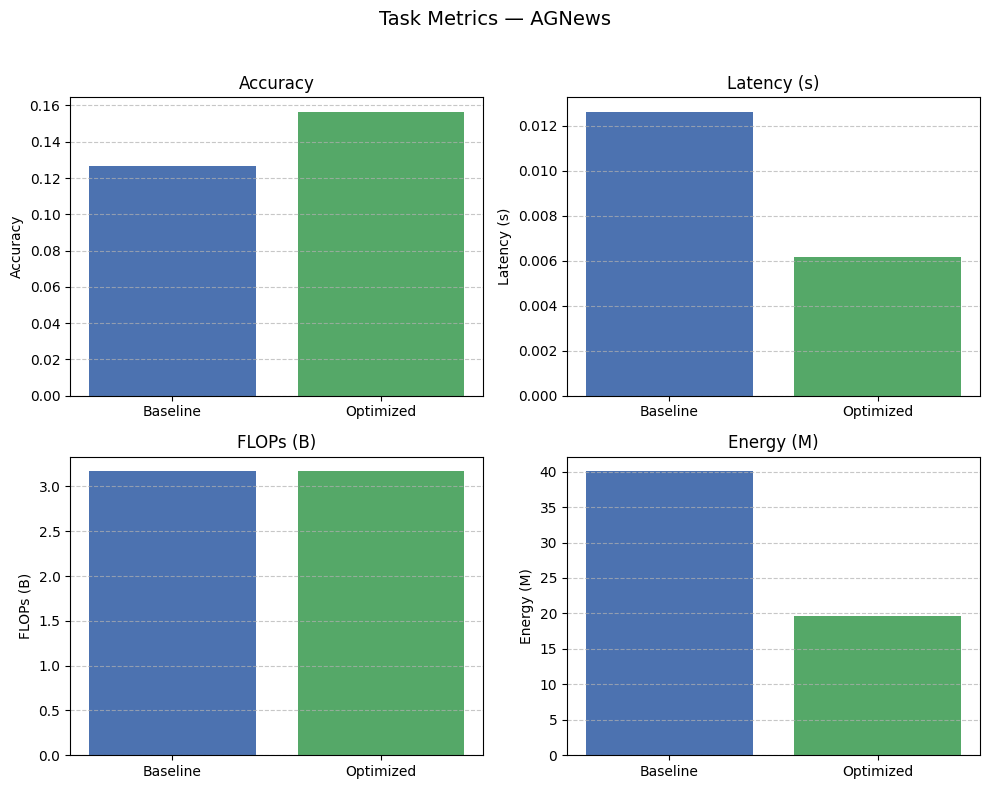


===== AGNews Results =====
Accuracy: Baseline=0.1267, Optimized=0.1567
Latency (s): Baseline=0.0126, Optimized=0.0062
FLOPs (B): Baseline=3.1709, Optimized=3.1709
Energy (M): Baseline=40.0801, Optimized=19.6281


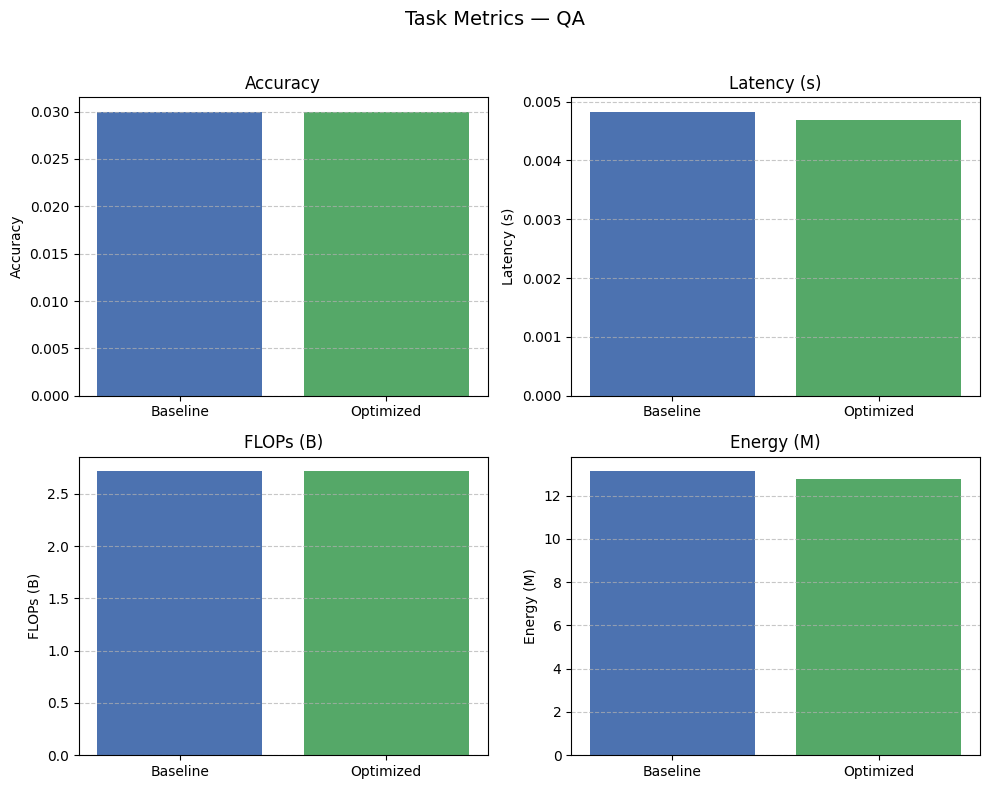


===== QA Results =====
Accuracy: Baseline=0.0300, Optimized=0.0300
Latency (s): Baseline=0.0048, Optimized=0.0047
FLOPs (B): Baseline=2.7179, Optimized=2.7179
Energy (M): Baseline=13.1336, Optimized=12.7467


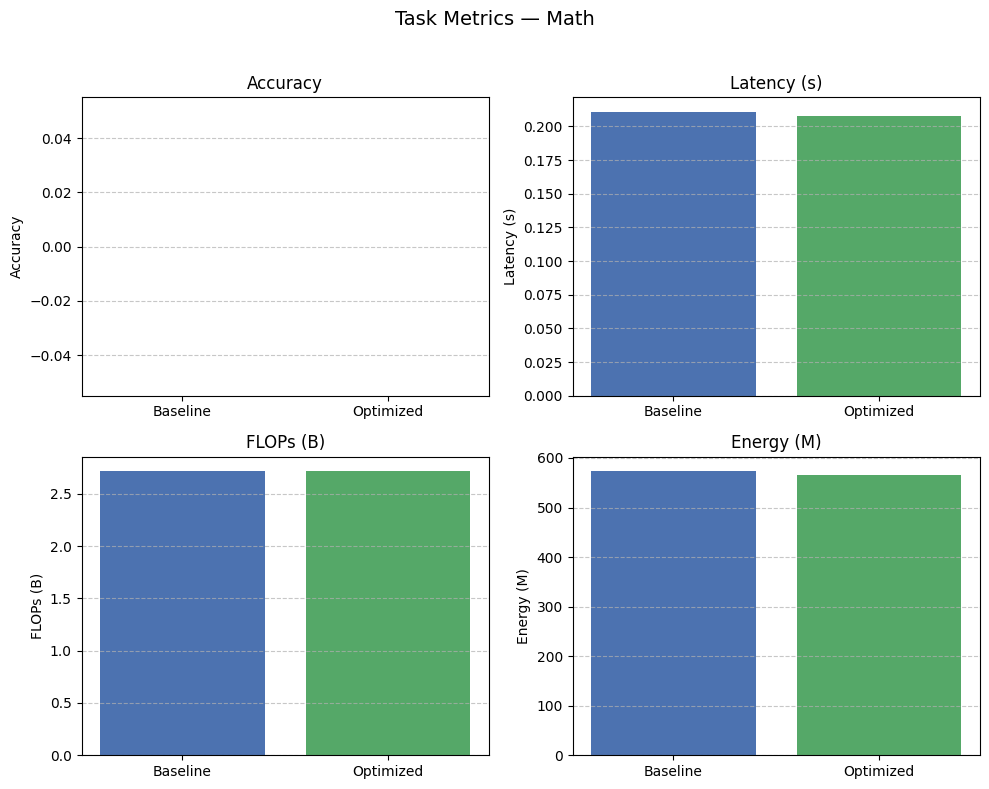


===== Math Results =====
Accuracy: Baseline=0.0000, Optimized=0.0000
Latency (s): Baseline=0.2110, Optimized=0.2079
FLOPs (B): Baseline=2.7179, Optimized=2.7179
Energy (M): Baseline=573.5846, Optimized=564.9264


In [45]:
def plot_task_metrics_subplots(task_name, task_results, scale_dict=None):
    """
    Create one figure with subplots (one per metric) for a given task.
    """
    metrics = ["accuracy", "latency_s", "avg_flops", "avg_energy"]
    labels = {
        "accuracy": "Accuracy",
        "latency_s": "Latency (s)",
        "avg_flops": "FLOPs (B)",
        "avg_energy": "Energy (M)"
    }
    if scale_dict is None:
        scale_dict = {"avg_flops": 1e9, "avg_energy": 1e6}

    baseline = task_results["Baseline"]
    opt = task_results["Optimized"]

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs = axs.flatten()

    for i, m in enumerate(metrics):
        scale = scale_dict.get(m, 1.0)
        b_val, o_val = baseline.get(m, 0)/scale, opt.get(m, 0)/scale

        axs[i].bar(["Baseline", "Optimized"], [b_val, o_val],
                   color=["#4C72B0", "#55A868"])
        axs[i].set_ylabel(labels[m])
        axs[i].set_title(labels[m])
        axs[i].grid(axis="y", linestyle="--", alpha=0.7)

    fig.suptitle(f"Task Metrics — {task_name}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Print raw values for reference
    print(f"\n===== {task_name} Results =====")
    for m in metrics:
        scale = scale_dict.get(m, 1.0)
        b_val, o_val = baseline.get(m, 0)/scale, opt.get(m, 0)/scale
        print(f"{labels[m]}: Baseline={b_val:.4f}, Optimized={o_val:.4f}")


# Example: plot for all tasks in one go
for task in results_all:
    plot_task_metrics_subplots(task, results_all[task])


# Interactive Evaluation

In [42]:
# --- Classification (AG News) ---
user_text = "The stock market crashed after inflation numbers were released."
enc = clf_tokenizer(user_text, truncation=True, padding="max_length", max_length=MAX_LEN, return_tensors="pt")
ids, mask = enc["input_ids"].to(device), enc["attention_mask"].to(device)
emb_feat = clf_model.get_input_embeddings()(ids).mean(dim=1).detach().cpu().float()
with torch.no_grad(): c = float(crit(emb_feat.to(device)).item())
keep_ratio, tau = route_from_crit(c)
ids_p, mask_p = prune_tokens_keep_anchors(ids, mask, keep_ratio)
(logits, used_layer, conf), latency = measure_latency_call(ee_ag.predict_until_exit, ids_p, mask_p, tau)
pred_label = int(logits.argmax(dim=-1).cpu().item())
print(" Classification Example")
print("Text:", user_text)
print("Predicted Label:", pred_label, "| Confidence:", conf, "| Latency:", latency, "s | Exit Layer:", used_layer+1)

# --- QA (SQuAD) ---
qa_ex = squad[10]
inputs = qa_tokenizer(qa_ex["question"], qa_ex["context"], return_tensors="pt", truncation=True, max_length=MAX_LEN).to(device)
logits, latency = measure_latency_call(lambda ids, mask: qa_model(input_ids=ids, attention_mask=mask),
                                       inputs["input_ids"].long(), inputs["attention_mask"])
start, end = torch.argmax(logits.start_logits), torch.argmax(logits.end_logits)
pred_text = qa_tokenizer.decode(inputs["input_ids"][0][start:end+1])
print("\n QA Example")
print("Q:", qa_ex["question"])
print("Predicted Answer:", pred_text, "| Latency:", latency, "s")
print("Gold Answer:", qa_ex["answers"]["text"][0])

# --- Math (GSM8K) ---
math_ex = gsm[5]
inputs = math_tokenizer(math_ex["question"], return_tensors="pt", truncation=True, max_length=MAX_LEN).to(device)
out_ids, latency = measure_latency_call(lambda ids, mask: math_model.generate(input_ids=ids.long(), attention_mask=mask, max_new_tokens=20, do_sample=False),
                                        inputs["input_ids"], inputs["attention_mask"])
pred_text = math_tokenizer.decode(out_ids[0].detach().cpu().tolist(), skip_special_tokens=True)
print("\n Math Example")
print("Q:", math_ex["question"])
print("Predicted:", pred_text, "| Latency:", latency, "s")
print("Gold:", math_ex["answer"])


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Classification Example
Text: The stock market crashed after inflation numbers were released.
Predicted Label: 2 | Confidence: 0.3088033199310303 | Latency: 0.018513202667236328 s | Exit Layer: 7

 QA Example
Q: What day was the Super Bowl played on?
Predicted Answer: what day was the super bowl played on? [SEP] super bowl 50 was an american football game to determine the champion of the national football league ( nfl ) for the 2015 season. the american football conference ( afc ) champion denver broncos defeated the national football conference ( nfc ) champion carolina panthers 24 | Latency: 0.020186424255371094 s
Gold Answer: February 7, 2016

 Math Example
Q: Kylar went to the store to buy glasses for his new apartment. One glass costs $5, but every second glass costs only 60% of the price. Kylar wants to buy 16 glasses. How much does he need to pay for them?
Predicted: Kylar went to the store to buy glasses for his new apartment. One glass costs $5, but every second glass costs on